In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize((0.5,), (0.5,))  # 평균과 표준편차를 사용하여 정규화
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# 신경망 정의
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            torch.nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            torch.nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            torch.nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = SimpleNN()

############### Your code here!!!
# 손실 함수와 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# 학습
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5
loss_value = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}")
            loss_value.append((running_loss / 100))
            running_loss = 0.0

print("Finished Training")

# 모델 저장
torch.save(model.state_dict(), 'mnist_simple_nn.pth')


[Epoch 1, Batch 100] Loss: 2.150
[Epoch 1, Batch 200] Loss: 1.747
[Epoch 1, Batch 300] Loss: 1.518
[Epoch 1, Batch 400] Loss: 1.368
[Epoch 1, Batch 500] Loss: 1.251
[Epoch 1, Batch 600] Loss: 1.162
[Epoch 1, Batch 700] Loss: 1.091
[Epoch 1, Batch 800] Loss: 1.029
[Epoch 1, Batch 900] Loss: 0.963


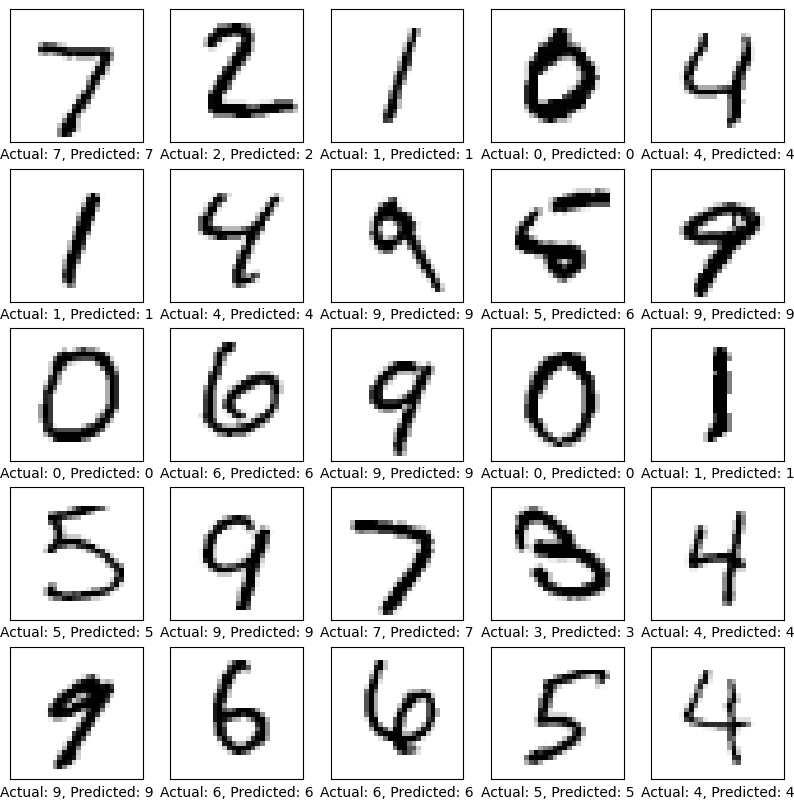

In [3]:
import matplotlib.pyplot as plt

# 학습 완료 후 테스트 데이터로 예측 수행
model.eval()
test_images, test_labels = next(iter(testloader))
test_images, test_labels = test_images.to(device), test_labels.to(device)
with torch.no_grad():
    test_outputs = model(test_images)
softmax = nn.Softmax(dim=1)
probabilities = softmax(test_outputs)
predicted_classes = torch.argmax(probabilities, dim=1)

# 이미지 및 예측 시각화
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i].cpu().numpy().squeeze(), cmap=plt.cm.binary)
    plt.xlabel(f'Actual: {test_labels[i]}, Predicted: {predicted_classes[i]}')
plt.show()


In [ ]:
# Plotting the loss values
plt.plot(loss_value, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()